In [15]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie
# from source.keras_utils import getPeaxFeatures
from source.torch_utils import getContrastiveFeatures
# import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [16]:
from source.datasets import loadFuncionalModel, loadNatops, loadWafer, loadSelfRegulationSCP2, loadBasicMotions, loadEarthquakes, loadItalyPowerDemand, loadEigenWorms

dataset = 'natops' # natops | wafer | selfreg | basicmotions | earthquakes | italy | eigenworms

if dataset == 'natops':
    X_train, y_train, X_test, y_test, classLabels = loadNatops()
elif dataset == 'wafer':
    X_train, y_train, X_test, y_test = loadWafer()
    classLabels = {}
elif dataset == 'basicmotions':
    X_train, y_train, X_test, y_test, classLabels= loadBasicMotions()

elif dataset == 'italy':
    X_train, y_train, X_test, y_test, classLabels= loadItalyPowerDemand()
# X = np.concatenate([X_train, X_test], axis=0).transpose([0, 2, 1])
# y = np.concatenate([y_train, y_test], axis=0)
# y = np.array([float(v) for v in y]).astype(int).tolist()

In [30]:
mts_train = TSerie(X=X_train.transpose([0, 2, 1]), y=y_train)
mts_test = TSerie(X=X_test.transpose([0, 2, 1]), y=y_test)

Loaded mts - N: 180, T: 51, D: 24 
Loaded mts - N: 180, T: 51, D: 24 


In [31]:
# mts.smooth(window_size=40)
# mts_train.shapeNormalizization()
# mts_test.shapeNormalizization()
# mts_train.minMaxNormalizization()
# mts_test.minMaxNormalizization()

In [61]:
# mts.folding_features_v2()
# mts.features, _ =  getPeaxFeatures(mts.X.transpose([0, 2, 1]), feat_size = 15, epochs =400, batch_size = 32)
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'shape'
EPOCHS = 150
BATCH_SIZE = 32
ENC_SIZE = 20
# MODE = 'shape'
mts_train.features, mts_test.features = getContrastiveFeatures(
    mts_train.X.transpose([0, 2, 1]), mts_train.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    X_test=mts_test.X.transpose([0, 2, 1]),
    encoding_size = ENC_SIZE,
)
# getContrastiveFeatures(mts.X, y)

Subsequence length: 45
Epoch[1] Train loss    avg: 2.450736939907074
Epoch[10] Train loss    avg: 1.4835476875305176
Epoch[20] Train loss    avg: 1.3792436520258586
Epoch[30] Train loss    avg: 1.3333934744199116
Epoch[40] Train loss    avg: 1.274438997109731
Epoch[50] Train loss    avg: 1.247290809949239
Epoch[60] Train loss    avg: 1.2264764904975891
Epoch[70] Train loss    avg: 1.2266669472058613
Epoch[80] Train loss    avg: 1.2008474469184875
Epoch[90] Train loss    avg: 1.1967088182767232
Epoch[100] Train loss    avg: 1.2149666547775269
Epoch[110] Train loss    avg: 1.185777723789215
Epoch[120] Train loss    avg: 1.1879006028175354
Epoch[130] Train loss    avg: 1.1684729655583699
Epoch[140] Train loss    avg: 1.1777639985084534
Epoch[150] Train loss    avg: 1.1594316363334656


In [62]:
from sklearn import svm

clf = svm.SVC()
clf.fit(mts_train.features, mts_train.y)

print(clf.score(mts_train.features, mts_train.y))
print(clf.score(mts_test.features, mts_test.y))

0.9722222222222222
0.8444444444444444


In [26]:
import umap

# reducer = umap.UMAP(n_components=2, metric='cosine')
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=12)
coords = reducer.fit_transform(mts.features)
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1])

NameError: name 'mts' is not defined

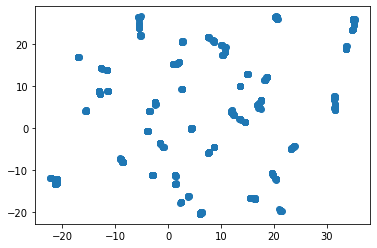

In [7]:
reducer = umap.UMAP(n_components=2, metric='braycurtis', n_neighbors=12)
coords_mean = reducer.fit_transform(mts.magnitudes)

plt.scatter(coords_mean[:, 0], coords_mean[:, 1])

Subsequence length: 21
Epoch[1] Train loss    avg: 3.864949417114258
Epoch[10] Train loss    avg: 1.7554753644125802
Epoch[20] Train loss    avg: 1.5317333902631487
Epoch[30] Train loss    avg: 1.4497439997536796
Epoch[40] Train loss    avg: 1.3884197916303362
Epoch[50] Train loss    avg: 1.3383143424987793


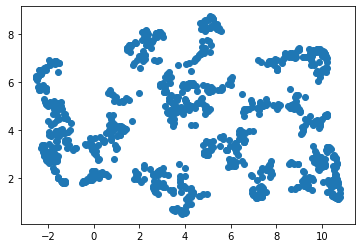

In [8]:
mts.features = getContrastiveFeatures(mts.X_norm.transpose([0, 2, 1]), y, epochs = EPOCHS, batch_size = BATCH_SIZE, loss_metric= LOSS, mode = MODE)
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=12)
coords_orig = reducer.fit_transform(mts.features)
plt.scatter(coords_orig[:, 0], coords_orig[:, 1])

In [9]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

In [10]:
storage = MTSStorage('mts')    
# storage.delete()
storage.load()

# classLabels = {int(v): str(v) for v in np.unique(y)}
dimensions = [str(dim) for dim in range(mts.D)]
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '{}_{}_{}'.format(dataset, LOSS, MODE),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords,
        'magnitude': coords_mean,
        'original': coords_orig,
    },
    sampling=True,
    n_samples= 400
)



storage.save()

mts shape: N: 1096 -  T: 24 - D: 2


In [11]:
type(list(classLabels.keys())[0])

int